In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable
from torch.nn import Parameter
from torch.nn import functional as F

from scipy.special import binom

import clingo
import numpy as np

import math
from IPython.display import clear_output

from numpy.random import random_integers as rndint
import pandas as pd
import copy
import random
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from SimpleMazeNewMarsh1 import *


def get_agent_pov(length, state, env):
    loc = torch.where(state[:, 1, :, :] == 100)
    x_locs = loc[1]
    y_locs = loc[2]
    #     length = 5

    bxl = np.maximum(x_locs - int(length / 2), 0)
    bxu = np.minimum(x_locs + int(length / 2) + 1, env.maze.shape[0])
    byl = np.maximum(y_locs - int(length / 2), 0)
    byu = np.minimum(y_locs + int(length / 2) + 1, env.maze.shape[0])

    current_M = env.get_super_manager_1([x_locs.item(), y_locs.item()])[1]
    for x in range(bxl.item(), bxu.item(), 1):
        for y in range(byl.item(), byu.item(), 1):
            m = env.get_super_manager_1([x, y])[1]

            if current_M == m:
                #             print(x,y)
                # if [x, y] != [x_locs, y_locs]:
                state[:, 1, x, y] = 50

    new_state = state[:, :, bxl:bxu,
                byl:byu]
    if y_locs - (int(length / 2)) < 0:
        s1 = np.minimum(np.abs(y_locs - (int(length / 2))), int(length / 2))
        s2 = 0
    elif (int(length / 2) + y_locs) > env.maze.shape[0] - 1:
        s1 = 0
        cc = np.abs(int(length / 2) + y_locs) + 1 - env.maze.shape[0]

        s2 = np.minimum(int(length / 2) + 1, cc)
    else:
        s1 = 0
        s2 = 0

    if x_locs - (int(length / 2)) < 0:
        s3 = np.minimum(np.abs(x_locs - (int(length / 2))), int(length / 2))
        s4 = 0
    elif (int(length / 2) + x_locs) > env.maze.shape[0] - 1:
        s3 = 0
        cc = np.abs(int(length / 2) + x_locs) + 1 - env.maze.shape[0]
        s4 = np.minimum(cc, int(length / 2) + 1)
    else:
        s3 = 0
        s4 = 0

    #     F.pad(new_state[:, 1, :, :], pad=(s1,s2,s3,s4),
    #                 value=0)
    a_1 = F.pad(new_state[:, 0, :, :], pad=(s1, s2, s3, s4),
                value=1)
    a_2 = F.pad(new_state[:, 1, :, :], pad=(s1, s2, s3, s4),
                value=1)
    # a_3 = F.pad(new_state[:, 2, :, :], pad=(s1, s2, s3, s4),
    #             value=1)
    blayer = torch.stack((a_1, a_2)).permute(1, 0, 2, 3)
    # print(blayer.size())
    return blayer


def clear():
    os.system('cls')


from collections import defaultdict
from tqdm import tqdm as tqdm


class QNetwork(nn.Module):

    def __init__(self, env, n_input, num_hidden, device, length):
        nn.Module.__init__(self)
        #         num_hidden=50
        self.num_hidden = num_hidden
        self.l1 = nn.Linear(n_input - 8, num_hidden)
        self.device = device
        self.l2 = nn.Linear(num_hidden, int(num_hidden))
        self.task_layer = nn.Linear(5, int(num_hidden))
        self.man_layer = nn.Linear(3, 1)
        self.man_layer.weight = torch.nn.Parameter(torch.tensor([1, env.manager_view, env.manager_view**2], dtype=torch.float).reshape(1, 3),
                                                   requires_grad=False)
        self.man_layer.bias = torch.nn.Parameter(torch.zeros_like(self.man_layer.bias), requires_grad=False)
        #         self.l4 = nn.Linear(num_hidden, num_hidden)
        self.l4 = nn.Linear(int(num_hidden), int(num_hidden))
        self.l3 = nn.Linear(int(num_hidden), 5)
        self.conv_1 = nn.Conv2d(2, 2, kernel_size=3, stride=1)
        #         if length<4:
        #             self.stride_x=4
        #             self.K=4

        #         else:
        #             self.stride_x=2
        self.K = env.maze.shape[0] - length + 1
        self.subsample = nn.AvgPool2d(kernel_size=env.manager_view, stride=env.manager_view, ceil_mode=True)
        self.loc = copy.copy(env.agent_init_state)
        self.length = length
        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]
        self.n_layers = env.n_layers
        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

        self.lims = self.get_super_manager_1(env, [env.maze.shape[1], env.maze.shape[1]])
        self.search_lims = [env.maze.shape[0] * 1.5 * x[0] for x in self.lims][::-1]
        self.search_lims[-1] = np.maximum(6, self.search_lims[-1])
        self.search_lims[0] = 10000000
        # self.blur_layer = BesselConv2d(1, zero_scale=0.25, base=2, n_scales=2)

    #         self.conv_layer =nn.Conv2d(1,1,env.maze.shape[0]-length+1,1)
    #         self.conv_layer.weight=torch.nn.Parameter(torch.ones_like(self.conv_layer.weight),requires_grad=False)
    #         self.conv_layer.bias=torch.nn.Parameter(torch.tensor(self.conv_layer.bias),requires_grad=False)
    #     # man_conv_layer=nn.Conv2d(2,2,4,1)
    # bb=get_agent_pov(5,state,env)

    def reset(self, env):
        self.loc = copy.copy(env.agent_init_state)

        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]

        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

    def forward(self, x, y, env):
        # try:
        #     x=x[:,:]
        # except:
        #     pass
        l = self.length
        el=env.maze.shape[0]
        if y != self.n_layers:
            #             # x1=self.conv_layer(x[:128].reshape(1,2,8,8))
            # x1=x1.flatten()
            pd = int(self.length / 2)
            mz = x.flatten()[:el**2].reshape(1, 1, el,el)

            aloc = x.flatten()[el**2:2*el**2].reshape(1,1, el, el)
            # gloc = x.flatten()[128:128 + 64].reshape(1, 1, 8, 8)
            # print(aloc)
            # print("1111111111111111111111111111======================")

            # print(aloc)
            mz = self.subsample(mz)
            aloc = self.subsample(aloc)
            # print("======================")
            # print(aloc)
            # gloc = self.subsample(gloc)
            mz = F.pad(mz[:
                       , :, :, :], pad=(pd, pd, pd, pd),
                       value=1)

            aloc = F.pad(aloc[:
                         , :, :, :], pad=(pd, pd, pd, pd),
                         value=.1)
            # print(aloc)
            # gloc = F.pad(gloc[:
            #              , :, :, :], pad=(pd, pd, pd, pd),
            #              value=1)

            pov = int(l / 2)

            # if torch.sum(aloc).item() > 1:
            #     print('hang on a second')
            _, _, xc, yc = torch.where(aloc == torch.max(aloc))
            # print(aloc)
            # print(xc,yc)
            xc = xc[0]  #
            yc = yc[0]
            mz = mz[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]
            # gloc = gloc[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]

            aloc = aloc[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]
            aloc = torch.ceil(aloc)
            aloc[:, :, 3, 3] = 100
            mz = torch.ceil(mz )

            mat_1 = mz.reshape(1, int(l ** 2))

            mat_2 = aloc.reshape(1, int(l ** 2))

            # mat_3 = gloc.reshape(1, int(l ** 2))
            #             print(mat_1)
            #             print(mat_2)
            #             x11=torch.cat((self.conv_layer(x.flatten()[:64].reshape(1,1,8,8)),self.conv_layer(x.flatten()[64:128].reshape(1,1,8,8)).reshape(1,int(l**2))),dim=1)
            # x11 = torch.cat((mat_1, mat_2), dim=1)
            # fig, axs = plt.subplots(4, 4, figsize=(15, 15))
            x11 = torch.stack((mat_1, mat_2)).view(1, 2, 7, 7)
            #             x=torch.cat((x11,x.flatten()[128:].reshape(1,8)),dim=1)
            # torch.stack((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(50,1).T,x[128:].flatten().reshape(8,1).T))
            #             x11=self.conv_1(x11)
            
            ll = len(x11.to(self.device).flatten())
#             print(ll)
#             print(x11)
            out = self.l1(x11.to(self.device).flatten().view(1, ll))
        else:
            state = x.flatten()[:2 * el**2].reshape(1, 2, el,el)
            x_1 = get_agent_pov(self.length, state, env)
            #             print(x_1.size())
            # x_1 = x_1[:, 0, :, :]
            #             x11 = self.conv_1(x_1)
            ll = len(x_1.to(self.device).flatten())
            out = self.l1(x_1.to(self.device).flatten().view(1, ll))
            # x=torch.cat((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(1,50),x[128:].flatten().reshape(1,8)),dim=1)
        # torch.cat((x_1,x[128:]))
        #             print(x_1.size())
        #             print(x)
        #             x_1=torch.cat((x_1.reshape(1,int(2*(l**2))),x.flatten()[128:].reshape(1,8)),dim=1)
        #         print(x)
        if x.size()[0] == 2 * el**2 + 8:
            x = x.unsqueeze(0)
        man = self.man_layer(x[:, 2*el**2:2*el**2+3].to(self.device))
        task = self.task_layer(x[:, 2*el**2+3:].to(self.device))
        #         print(out.size(),man.size(el**2,task.size())

        #         out = self.l2(F.relu(out))
        out = F.relu(out) * F.relu(task)
        #         out = self.l4(F.relu(out))
        out = self.l3(F.relu(out)) * man
        return out

    def init_super_manager(self, env):
        n_layers = env.n_layers + 1
        self.super_managers = []
        number_of_levels = n_layers
        self.super_managers.append([np.floor(x / env.manager_view) for x in self.loc])
        if number_of_levels - 2 > 1:
            for i in range(int(number_of_levels - 2)):
                self.super_managers.append([np.floor(x / env.manager_view) for x in self.super_managers[-1]])
        else:
            self.super_managers.append([0, 0])
        self.super_managers = self.super_managers[::-1]

    def get_super_manager_1(self, env, loc):
        #         find which super manager per finest location state
        super_managers = []
        number_of_levels = int(env.n_layers)
        #         super_managers.append([np.floor(x/(2**(number_of_levels-1)/2)) for x in current_state])
        # print(loc)
        super_managers.append([np.floor(x / env.manager_view) for x in loc])
        if number_of_levels - 1 > 1:
            for i in range(number_of_levels - 1):
                super_managers.append([np.floor(x / env.manager_view) for x in super_managers[-1]])
        #                 print(i)
        else:
            super_managers.append([0, 0])
        return super_managers[::-1]

    # def get_subs(self, mans, env, level):
    #     if level == 0:
    #         subs = []
    #         for x in range(env.maze.shape[0]):
    #             for y in range(env.maze.shape[0]):
    #                 subs.append([x, y])
    #         #                     index_list.append(x*env.maze.shape[0]+y)
    #         return np.array([int(x) for x in list(range(env.maze.shape[0] ** 2))]), subs
    #     else:
    #         step_view = env.manager_view
    #         xs = []
    #         ys = []
    #         step_view = 2
    #
    #         for i in range(0, step_view, 1):
    #             xs.append(mans[0] * step_view + i)
    #         for i in range(0, step_view, 1):
    #             ys.append(mans[1] * step_view + i)
    #         subs = []
    #         index_list = []
    #         for x in xs:
    #             for y in ys:
    #                 subs.append([x, y])
    #                 index_list.append(x * env.maze.shape[0] + y)
    #
    #         return np.array([int(x) for x in index_list]), subs
    def get_subs(self, mans, env, level):
        if level == 0:
            subs = []
            for x in range(env.maze.shape[0]):
                for y in range(env.maze.shape[0]):
                    subs.append([x, y])
            #                     index_list.append(x*env.maze.shape[0]+y)
            return np.array([int(x) for x in list(range(env.maze.shape[0] ** 2))]), subs
        else:
            step_view = env.manager_view ** (env.n_layers - level)
            xs = []
            ys = []
            #             step_view = 2

            for i in range(0, step_view, 1):
                xs.append(mans[0] * step_view + i)
            for i in range(0, step_view, 1):
                ys.append(mans[1] * step_view + i)
            subs = []
            index_list = []
            for x in xs:
                for y in ys:
                    subs.append([x, y])
                    index_list.append(x * env.maze.shape[0] + y)

            return np.array([int(x) for x in index_list]), subs

def get_epsilon(it):
    # YOUR CODE HERE
    #     raise NotImplementedError

    epsilon = np.maximum(.5 + - .5 * ((it) / 15000), .1)

    #     return epsilon
    return epsilon


class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """

    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon

    def sample_action(self, obs, allowed_actions, i, num_eps, level):
        """
        This method takes a state as input and returns an action sampled from this policy.

        Args:
            obs: current state

        Returns:
            An action (int).

        """
        if level == 2:
            eps = np.maximum(self.epsilon, .5 - .5 * (i * 1.15 / num_eps))
        else:
#             eps=0.1
            eps = np.maximum(self.epsilon, .5 - .5 * (i * 1.8 / num_eps))
        #         eps=0.25
        # YOUR CODE HERE
        #         raise NotImplementedError
        with torch.no_grad():

            # Pytorch can be pretty annoying with its data types!
            state = torch.tensor(obs, dtype=torch.float)

            # get the q values for each action given by the model
            q_sa = self.Q.forward(state, level, env)
            #             print(q_sa)
            # random number to decice each action to take
            choice = torch.rand(1).item()

            if choice < eps:
                # Uniform sampling
                return np.random.choice(allowed_actions), eps

            else:
                # Select the greedy action
                a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]
                return a, eps

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon


def compute_q_vals(Q, states, ys, env, actions):
    ss=states.clone()
    return Q.forward(ss, ys, env).gather(dim=1, index=actions).squeeze()


def compute_targets(Q, rewards, states, next_states, dones, discount_factor, allowed_actions_current,
                    allowed_actions_next, ys, env, reason):
    #     try:

    #     print(ys)
    #     print(ys!=env.n_layers)
    reason=reason[0]
    if ys.item() != env.n_layers:
        if dones:
            targets = rewards
        else:

            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_next[x[0]]] for x in
                                                                enumerate(Q.forward(next_states, ys, env))]]).reshape(
                len(next_states), 1) * (1 - dones).float()
    else:
        if dones:
            targets = rewards
        #                 TS
        elif reason in [1, 3]:
            targets = rewards

        #             TF
        #         elif reason==3:
        #     #                 man_state=env.get_super_manager_1(ns)[level-1]
        #     #                 ms=man_state[0] * self.layer_states[level-1] + man_state[1]
        #     #                 task=tasks[level-2]
        #     #                 maxq=np.max([self.Q_table[level][ms][task][a] for  a in allowed_future_actions])
        #             targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
        #                                                            [x[1][allowed_actions_current[x[0]]] for x in
        #                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
        #             len(states), 1) * (1 - dones).float()
        # #         + discount_factor * torch.stack([torch.max(y) for y in
        # #                                                            [x[1][allowed_actions_current[x[0]]] for x in
        # #                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
        # #             len(states), 1) * (1 - dones).float()

        # sl
        elif reason == 2:

            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_current[x[0]]] for x in
                                                                enumerate(Q.forward(states, ys, env))]]).reshape(
                len(states), 1) * (1 - dones).float()
        # no managerial change
        else:
            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_next[x[0]]] for x in
                                                                enumerate(Q.forward(next_states, ys, env))]]).reshape(
                len(next_states), 1) * (1 - dones).float()

    #     except:
    #         print('aaa')
    return targets


class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)

        if len(self.memory) > self.capacity:
            self.memory = self.memory[-self.capacity:]

    def sample(self, batch_size):
        idxs = np.random.randint(len(self.memory), size=batch_size)

        return np.array(self.memory)[idxs]

    def __len__(self):
        return len(self.memory)


def train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler):
    # DO NOT MODIFY THIS FUNCTION

    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None
    device = torch.device(dev)
    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)

    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done, allowed_actions_next, ys, reason, allowed_actions_current = zip(
        *transitions)

    # convert to PyTorch and define types
    # state = torch.stack(state).squeeze(1).to(device)
    state = torch.tensor(state, dtype=torch.float).to(device)
    ys = torch.tensor(ys, dtype=torch.float).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)[:, None]  # Need 64 bit to use them as index
    # next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(1).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float).to(device)
    reward = torch.tensor(reward, dtype=torch.float).to(device)[:, None]
    done = torch.tensor(done, dtype=torch.uint8).to(device)[:, None]  # Boolean
    # allowed_actions_next=torch.tensor(allowed_actions_next, dtype=torch.int64).to(device)

    # compute the q value
    q_val = compute_q_vals(Q_policy, state, ys, env, action)

    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q_target, reward, state, next_state, done, discount_factor, allowed_actions_current,
                                 allowed_actions_next, ys, env, reason)
        # print('target', target)
    loss = F.mse_loss(q_val.reshape(batch_size, 1), target)
    # clear()
    # print(env.loc,flush=True)
    # print(loss.item(),flush=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item()


# loc_maze=np.zeros((env.maze.shape[0],env.maze.shape[0]))
# loc_maze[Q_policy.loc[0],Q_policy.loc[1]]=1
#
# a=torch.tensor(env.maze)
# b=torch.tensor(loc_maze)
# c=torch.stack((a,b)).float()
# d=a1(c.unsqueeze(0))
# state=c.unsqueeze(0)
#
# # stride
# man_conv_layer=nn.Conv2d(2,2,4,1)
# bb=get_agent_pov(5,state,env)
# man_conv_layer(state).squeeze(0).flatten().detach().numpy()
def print_policy(Q_policy, env, val_1, val_2):
    j = []
    jv = []
    j1v = []

    lisv = []
    sm = []
    for y in range(8):
        for j2 in range(8):
            a = env.get_super_manager_1([y, j2])
            if a[-1] not in sm:
                lisv.append(y * 8 + j2)
                sm.append(a[-1])
    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(64 + 72)
        state[:64] = torch.tensor(env.maze.flatten())
        m = 1

        aa = env.possible_actions(m, [int(s / 8), s % 8])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, 1)

        t = 4
        state[64:128] = 0
        state[64 + loc_idx2] = 1
        state[128 + m] = 1
        state[131 + t] = 1
        #         print(state)

        j.append(action_dict[aa[torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[1].item()]])
        j1v.append(torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[0].item())
        jv.append([(x, Q_policy.forward(state, 1, env).flatten()[x].item()) for x in aa])
    print(np.array(j).reshape(4, 4))
    print(np.array(jv).reshape(4, 4))

    j2 = []
    j2v = []
    value_list = {}
    # lisv=np.sort([2*x for x in range(0,32,8)]+[2*x for x in range(1,33,8)]+[2*x for x in range(2,34,8)]+[2*x for x in range(3,35,8)])
    for s in range(64):

        #     if int(s/8)+s%8<16:
        state = torch.zeros(64 + 72)
        state[:64] = torch.tensor(env.maze.flatten())
        #         aa=env.possible_actions(m,[int(s/8),s%8])
        state[64:128] = val_2
        m = 2
        p = int(s / 16) * 4 + int((s / 2) % 4)
        t = action_dict_r[j[p]]
        gm = env.get_super_manager_1([int(s / 8), int(s % 8)])[1]
        for x in range(64):
            sm = env.get_super_manager_1([int(x / 8), int(x % 8)])[1]
            if sm == gm:
                state[64 + x] = 0

        state[s + 64] = 1
        state[128 + m] = 1
        state[131 + t] = 1
        #         print(p, s, m, t)
        #         print()
        #         print(state)
        if [int(s / 8), int(s % 8)] == g:
            j2.append('X')
            j2v.append(0)
        elif env.maze[int(s / 8), int(s % 8)] == 1:
            vv = Q_policy.forward(state, 2, env)
            j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
        else:
            vv = Q_policy.forward(state, 2, env)
            value_list[s] = vv.cpu().detach().numpy()
            j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    print(np.array(j2).reshape(8, 8
                               ))
    print('xxx')

    V = np.array(j1v)
    cells = [[x, y] for x in range(4) for y in range(4)]
    policy = np.array(j).reshape(4, 4)

    fig, ax = plt.subplots()
    im = ax.imshow(np.reshape(V, (-1, 4)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        #     if env.good_cell[cell[0],cell[1]]==1:
        #         text = ax.text(cell[1], cell[0], "Ma",
        #                        ha="center", va="center", color="w")

        if cell == env.get_super_manager_1(env.goal_init_state)[1]:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w")
        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    plt.title('Policy Managerial level')

    plt.show()
    # print('cccc')

    # levlel_2_policy={x:action_map[2][x][t] for x in action_map[2].keys()}
    V = np.array(j2v)
    cells = [[x, y] for x in range(8) for y in range(8)]
    policy = np.array(j2).reshape(8, 8)

    fig, ax = plt.subplots()
    V = np.sign(V) * (np.abs(V) ** 0.5)
    im = ax.imshow(np.reshape(V, (-1, 8)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        if cell == env.goal_init_state:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w", weight='bold')
        elif env.maze[cell[0], cell[1]] == 1:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]] + '_M',
                           ha="center", va="center", color="w")

        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    fig.set_size_inches(18.5, 10.5)
    plt.title('Policy lower level')
    plt.show()
    print('cccc')


def run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                 min_episodes):
    optimizer = optim.AdamW(Q_policy.parameters(), learn_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01,
                            amsgrad=False)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_episodes, eta_min=0)
    dev = 'cpu'
    global_steps = 0
    losses = []
    rewards = []
    dd = []
    # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    Visit_table = {}
    for l in range(env.n_layers + 1):
        Visit_table[l] = {}
        for s in range(env.maze.shape[0] ** 2):
            Visit_table[l][s] = {}
            for t in range(5):
                Visit_table[l][s][t] = {}
                for a in range(5):
                    Visit_table[l][s][t][a] = 0
    pos_man = 64
    ss = []
    #     int((env.maze.shape[0]/env.manager_view)**2)
    for i in tqdm(range(num_episodes)):

        # if i % 2000:
        #     env.reset(True)
        #
        # else:
        env.reset(True)
        print(env.goal_init_state)
        g = copy.copy(env.goal_init_state)
        ss.append(env.agent_init_state)
        #         Q_policy.loc=copy.copy(env.agent_init_state)
        #         Q_target.loc=copy.copy(env.agent_init_state)
        Q_policy.reset(env)
        Q_target.reset(env)

        #         print('Goal', env.goal_init_state)
        #         print('Agent', Q_policy.loc)
        # agent_row = env.maze.flatten()
        agent_row = copy.copy(env.maze)
        #         agent_row[int(state[0])][int(state[1])] = 1
        #         n_agent_row_1 = np.reshape(agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
        #         state = torch.tensor(n_agent_row_1, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
        step_counter = 0
        if i > min_episodes:
            if pd.Series(episode_durations).rolling(300).mean().tail(1).values[0] < 5.:
                print('average less than 4.5')
                d = True
            else:
                d = False
                if i > 10000:
                    a = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().shift(100)
                    a2 = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().expanding().min()
                    if a.abs().rolling(100).mean().tail(1).values[0] < .01:
                        print(a.abs().rolling(100).mean().tail(1).values[0])
                        print('Converged')
                        d = True
                    elif a2.tail(1).values[0] > np.maximum(pd.Series(episode_durations).rolling(300).mean().min(), 200):
                        print('Diverged')
                        d = True


                    elif a.rolling(3).mean().tail(1).values[0] > 1000:
                        print('Diverged')
                        d = True

                    else:
                        d = False
                    if pd.Series(losses).rolling(999).mean().tail(1).values[0] < 4:
                        d = True
        #             if pd.Series(rewards).rolling(100).mean().tail(1).values[0]>-8:
        #                     d=True
        # if pd.Series(episode_durations).rolling(200).mean().tail(1).values[0] - \
        #         pd.Series(episode_durations).rolling(200).mean().shift(-20).dropna().tail(1).values[0] > 30:
        #     d = True

        else:
            d = False
        old_step_counter = 0
        r2 = 0
        #         clear_output(wait=True)

        while d != True:
            # env.current_level=2
            # print('Current position', Q_policy.loc)
            level2 = copy.copy(Q_policy.current_level)
            state_1 = copy.copy(Q_policy.loc)
            current_loc = copy.copy(Q_policy.loc)
            # print(current_loc)
            current_level = copy.copy(Q_policy.current_level)
            allowed_actions = env.possible_actions(current_level, current_loc)

            state = np.zeros(2 * env.maze.shape[0] ** 2 + 8)
            #             if current_level==env.n_layers:
            state[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            g_idx2 = int(env.maze.shape[0] * g[0] + g[1])
            if current_level == 0:
                loc_idx2 = 0
                g_idx2 = 0

            #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
            #                                                  current_level)
            elif current_level != env.n_layers:
                #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
                #                                                  current_level)
                # loc_idx2 = int(current_loc[0] / 2) * 4 + int(current_loc[1] / 2)
                loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc], env, current_level)
                g_idx2, locsg = Q_policy.get_subs([int(x / env.manager_view) for x in g], env, current_level)
            #                 loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     state[jl + env.maze.shape[0] ** 2] = .1
            state[g_idx2 +  env.maze.shape[0] ** 2] = -100

            state[loc_idx2 + env.maze.shape[0] ** 2] = 100
            man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
            state[man_idx] = 1
            cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1

            if current_level != 0:
                task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                ttt = Q_policy.hierarchy_actions[current_level - 1]
            else:
                task_idx = cc + 4
                ttt = 4
            state[task_idx] = 1

            if level2 == env.n_layers:
                old_step_counter = step_counter
                step_counter = step_counter + 1
                global_steps = global_steps + 1

            epsilon = get_epsilon(global_steps)
            epg = EpsilonGreedyPolicy(Q_policy, epsilon)
            if current_level == 0:
                a = 4
            else:
                a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)
            # print('Action', allowed_actions, a)
            #             env.check_dicts[0][current_level][a] += 1
            if current_level == env.n_layers:
                Visit_table[current_level][loc_idx2][ttt][a] += 1
            elif current_level == env.n_layers - 1:
                loc_level = int(current_loc[0] / 2) * 4 + int(current_loc[1] / 2)
                Visit_table[current_level][loc_level][ttt][a] += 1
            ns, d = env.step(a, current_level, Q_policy)
            #             print(current_loc,a,ns)
            nl = copy.copy(Q_policy.current_level)
            # print('NewState', ns)
            # print('New level', Q_policy.current_level)
            #             print('----------------------------------------')
            #             print('Goal:', i, env.goal_init_state)
            #             print(current_loc, current_level)
            #             print(allowed_actions, a)
            #             print(ns, Q_policy.current_level)
            #             print('----------------------------------------')
            Q_policy.loc = copy.copy(ns)
            if step_counter > 0:
                if Q_policy.current_level != 0:
                    env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy, False)
                else:
                    Q_policy.expected_level = copy.copy(Q_policy.current_level)
            else:
                Q_policy.expected_level = copy.copy(Q_policy.current_level)

            old_reset = copy.copy(env.reset_reward)
            #             if current_level==2:
            #                 print(env.reset_reward,env.reset_reward_2)

            r = env.reward(Q_policy, d, current_level)
            #             if current_level==2:
            #                 print(r)
            if d == True:
                env.reset_reward = [5 for x in env.reset_reward]

            n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2 + 8)
            #             if current_level == env.n_layers:
            n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
            loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
            g_idx2 = int(env.maze.shape[0] * g[0] + g[1])
            if Q_policy.expected_level == 0:
                loc_idx2 = 0
                g_idx2 = 0
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)
            elif Q_policy.expected_level != env.n_layers:
                rf = env.manager_view ** (env.n_layers - current_level)
                loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in ns], env, current_level)

                # loc_idx2 = int(ns[0] / 2) * 4 + int(ns[1] / 2)
                g_idx2, locsg = Q_policy.get_subs([int(x / rf) for x in g], env, current_level)
            #                 loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     n_agent_row[jl + env.maze.shape[0] ** 2] = .10
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)
            #             print(loc_idx2)
            n_agent_row[g_idx2 +  env.maze.shape[0] ** 2] = -100

            n_agent_row[env.maze.shape[0] ** 2 + loc_idx2] = 100
            man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
            n_agent_row[man_idx] = 1
            if nl != 0:
                task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
            else:
                task_idx = cc + 4
            n_agent_row[task_idx] = 1
            #             print('-ll-')
            #             print(state)
            #             print(n_agent_row)
            for x in enumerate(old_reset):
                level = x[0]
                x = x[1]
                reason = x
                allowed_actions_next = env.possible_actions(level, ns)
                #                 env.get_possible_actions(ns, level)
                allowed_actions_current = env.possible_actions(level, state_1)
                if level2 == env.n_layers:
                    r2 += r[-1]
                    if level == env.n_layers:

                        assert allowed_actions_next == [0, 1, 2, 3]
                        memory.push((state, a, r[level], n_agent_row, d, allowed_actions_next, level, reason,
                                     allowed_actions_current))
                        loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler)
                        losses.append(loss)
                    else:

                        if x not in [0]:
                            if level not in [env.n_layers, 0]:
                                # print(ns,level)
                                if env.get_super_manager_1(ns)[level] == env.get_super_manager_1(env.goal_init_state)[
                                    level]:
                                    # try:
                                    if env.search_clause == True:
                                        allowed_actions_next == [4]

                                else:
                                    if env.search_clause == True:
                                        assert all(a in [0, 1, 2, 3, ] for a in allowed_actions_next)
                                    else:
                                        assert all(a in [0, 1, 2, 3, 4] for a in allowed_actions_next)

                                state_ll = np.zeros(2 * env.maze.shape[0] ** 2 + 8)
                                #                             loc_idx = int(env.maze.shape[0] * state_l[0] + state_l[1])
                                state_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level == 0:
                                    loc_idx2 = 0
                                    g_idx2 = 0
                                #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                #                                                                      level)
                                elif level == 1:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(state_1[0] / env.manager_view) * 4 + int(
                                    #     state_1[1] / env.manager_view)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
                                                                       env, level)
                                    g_idx2, locsg = Q_policy.get_subs([int(x / env.manager_view) for x in g], env,
                                                                      level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         state_ll[jl + env.maze.shape[0] ** 2] = .1
                                state_ll[g_idx2 + env.maze.shape[0] ** 2] = -100
                                state_ll[loc_idx2 + env.maze.shape[0] ** 2] = 100

                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                state_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level - 1]
                                else:
                                    task_idx = cc + 4
                                state_ll[task_idx] = 1

                                n_agent_row_ll = np.zeros(2 * env.maze.shape[0] ** 2 + 8)
                                #                             loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                                n_agent_row_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level != 0:
                                    level3 = level - 1
                                else:
                                    level3 = 0
                                if level == 0:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)

                                    loc_idx2 = 0
                                    g_idx2 = 0
                                elif level == 1:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(ns[0] / env.manager_view) * 4 + int(ns[1] / env.manager_view)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in Q_policy.loc],
                                                                       env, level)
                                    g_idx2, locsg = Q_policy.get_subs([int(x / env.manager_view) for x in g], env,
                                                                      level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         n_agent_row_ll[jl + env.maze.shape[0] ** 2] = .1
                                n_agent_row_ll[g_idx2 + env.maze.shape[0] ** 2] = -100
                                n_agent_row_ll[loc_idx2 + env.maze.shape[0] ** 2] = 100

                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                n_agent_row_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level3]
                                else:
                                    task_idx = cc + 4
                                n_agent_row_ll[task_idx] = 1
                                #                                 print('ll')
                                #                                 print(state_ll)
                                #                                 print(n_agent_row_ll)

                                #                         update q values
                                memory.push((state_ll, a, r[level], n_agent_row_ll, d, allowed_actions_next, level,
                                             reason, allowed_actions_current))
                                loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev,
                                             scheduler)
                                losses.append(loss)

            #             n_agent_row = np.reshape(n_agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
            #             n_agent_row = torch.tensor(n_agent_row, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
            state = n_agent_row
            Q_policy.current_level = copy.copy(Q_policy.expected_level)
            Q_target.current_level = copy.copy(Q_policy.expected_level)
            Q_target.loc = copy.copy(Q_policy.loc)
            Q_target.expected_level = copy.copy(Q_policy.expected_level)
            Q_target.current_tasks_loc = copy.copy(Q_policy.current_tasks_loc)
            Q_target.tasks = copy.copy(Q_policy.tasks)
            Q_target.tasks_bools = copy.copy(Q_policy.tasks_bools)
            Q_target.hierarchy_actions = copy.copy(Q_policy.hierarchy_actions)

            if d != True:
                env.reset_rewards_after_learning(old_reset)

            if step_counter > 10000:
                print('diverged')
                break
            if d:
                episode_durations.append(step_counter)
                rewards.append(r2)
                break
            #             if step_counter > 500:
            #                 if step_counter % 50:
            #                     print(current_loc,ns,a)
            #             if step_counter> 20*(env.maze.shape[0]**2) :
            #                 print('TMS')
            #                 break

            #             Q_target = soft_update(Q_policy, Q_target, tau=1e-3)
            Q_target = copy.copy(Q_policy)
        if i % 50 == 0:
            #                 print(env.check_dicts)
            #                 print(env.loc)
            if i % 300:
                clear_output(wait=True)
            #                 print_policy(Q_policy, env, 0, 0)
            print('epsilon', eps)
            if i > 300:
                dd.append(pd.Series(episode_durations).rolling(300).mean().min())
                print(dd)
                print('min mean', pd.Series(episode_durations).rolling(300).mean().min())
                print('last mean', pd.Series(episode_durations).rolling(300).mean().tail(1))
    #             Q_talastrget.load_state_dict
    #             Q_target.load_state_dict(Q_policy.state_dict())
    return episode_durations, losses, Visit_table, rewards, ss


def soft_update(local_model, target_model, tau):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    return target_model


# env=Normal_Maze(22)

action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}







In [ ]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




import matplotlib.pyplot as plt



env = Hierarchical_Maze(16
                        , 2, 4, 2, False,False,2,
                        False,0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0
env.goal_init_state=[4,4]


# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes = 20000
batch_size = 1
discount_factor =1
learn_rate = 1e-5
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_3={}

device = torch.device("cpu")

for length in [7]:
#     for num_hidden in  [int(n_input*1.1)]:
# counter=0
    n_input = 2*length ** 2 + 8

    for num_hidden in  [int(length ** 2)]:
#                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
#     for length in [3]:
        memory = ReplayMemory(1)



        Q_policy = QNetwork(env, n_input, num_hidden, device,length).to(device)
        Q_target = QNetwork(env, n_input, num_hidden, device,length).to(device)

        # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
        # Q_target = QNetwork(n_input, num_hidden, device).to(device)

        # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
        # target_net = DQN(screen_height, screen_width, n_actions).to(device)
        Q_target.load_state_dict(Q_policy.state_dict())
        Q_target.eval()
        allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

        policy = EpsilonGreedyPolicy(Q_policy, 0.08)

        episode_durations, losses, Visit_table,rewards,ss = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                              batch_size,
                                                              discount_factor, learn_rate, np.minimum(500,num_episodes))
        r_dict_3[counter]={'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                         'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
        counter=counter+1
#         import matplotlib.pyplot as plt
#         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






 49%|██████████████████████████████████▉                                     | 9702/20000 [22:25:15<7:52:02,  2.75s/it]

epsilon 0.22112500000000002
[1510.8433333333332, 1349.5333333333333, 1197.1666666666667, 1123.6333333333334, 922.1966666666667, 856.5833333333334, 780.32, 730.1166666666667, 730.1166666666667, 730.1166666666667, 730.1166666666667, 730.1166666666667, 730.1166666666667, 730.1166666666667, 730.1166666666667, 665.8, 611.7833333333333, 601.8033333333333, 568.72, 552.25, 518.03, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 514.7266666666667, 478.1333333333333, 478.1333333333333, 478.1333333333333, 478.1333333333333, 478.1333333333333, 478.1333333333333, 478.1333333333333, 478.1333333333333, 478.1333333333333, 478.1333333333333, 478.1333333333333, 478.1333333333333, 478.1333333333333, 478.1333333333333, 478.133333333333

 49%|██████████████████████████████████▉                                     | 9703/20000 [22:25:17<6:43:37,  2.35s/it]

[3, 7]


 49%|██████████████████████████████████▉                                     | 9704/20000 [22:25:17<5:04:37,  1.78s/it]

[2, 11]


 49%|██████████████████████████████████▉                                     | 9705/20000 [22:25:17<3:51:14,  1.35s/it]

[7, 4]


 49%|██████████████████████████████████▉                                     | 9706/20000 [22:25:18<3:09:34,  1.10s/it]

[11, 6]


 49%|██████████████████████████████████▉                                     | 9707/20000 [22:25:20<3:41:12,  1.29s/it]

[9, 7]


 49%|██████████████████████████████████▉                                     | 9708/20000 [22:25:20<3:01:34,  1.06s/it]

[9, 12]


 49%|██████████████████████████████████▉                                     | 9709/20000 [22:25:25<6:13:41,  2.18s/it]

[6, 10]


 49%|██████████████████████████████████▉                                     | 9710/20000 [22:25:27<6:14:23,  2.18s/it]

[13, 7]


 49%|██████████████████████████████████▉                                     | 9711/20000 [22:25:27<4:33:10,  1.59s/it]

[4, 4]


 49%|██████████████████████████████████▉                                     | 9712/20000 [22:25:33<8:13:09,  2.88s/it]

[13, 5]


 49%|██████████████████████████████████▉                                     | 9713/20000 [22:25:38<9:52:21,  3.45s/it]

[6, 11]


 49%|██████████████████████████████████▉                                     | 9714/20000 [22:25:39<8:03:15,  2.82s/it]

[1, 10]


 49%|██████████████████████████████████▍                                    | 9716/20000 [22:26:40<40:08:20, 14.05s/it]

[6, 12]
[2, 10]


 49%|██████████████████████████████████▍                                    | 9717/20000 [22:26:51<38:06:39, 13.34s/it]

[6, 10]


 49%|██████████████████████████████████▌                                    | 9719/20000 [22:27:09<29:25:40, 10.30s/it]

[9, 4]
[14, 13]


 49%|██████████████████████████████████▌                                    | 9720/20000 [22:27:11<22:06:05,  7.74s/it]

[8, 7]


 49%|██████████████████████████████████▌                                    | 9721/20000 [22:27:16<19:42:27,  6.90s/it]

[1, 10]


 49%|██████████████████████████████████▌                                    | 9722/20000 [22:27:45<39:04:43, 13.69s/it]

[10, 6]


 49%|██████████████████████████████████▌                                    | 9723/20000 [22:27:49<30:27:07, 10.67s/it]

[11, 11]
[11, 6]


 49%|██████████████████████████████████▌                                    | 9725/20000 [22:27:52<22:49:05,  7.99s/it]

[2, 4]


 49%|██████████████████████████████████▌                                    | 9726/20000 [22:27:54<17:02:28,  5.97s/it]

[12, 0]


 49%|██████████████████████████████████▌                                    | 9727/20000 [22:27:56<13:58:17,  4.90s/it]

[8, 10]


 49%|██████████████████████████████████▌                                    | 9728/20000 [22:27:59<12:07:48,  4.25s/it]

[8, 1]


In [14]:
Q_policy


QNetwork(
  (l1): Linear(in_features=98, out_features=49, bias=True)
  (l2): Linear(in_features=49, out_features=49, bias=True)
  (task_layer): Linear(in_features=5, out_features=49, bias=True)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
  (l4): Linear(in_features=49, out_features=49, bias=True)
  (l3): Linear(in_features=49, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=4, stride=4, padding=0)
)

<AxesSubplot:>

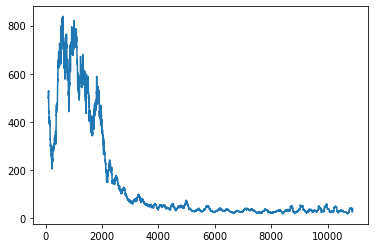

In [13]:
pd.Series(episode_durations).rolling(100).mean().plot()

<AxesSubplot:>

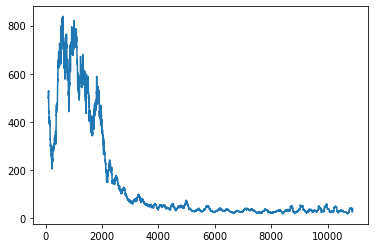

In [14]:
pd.Series(episode_durations).rolling(100).mean().plot()

<AxesSubplot:>

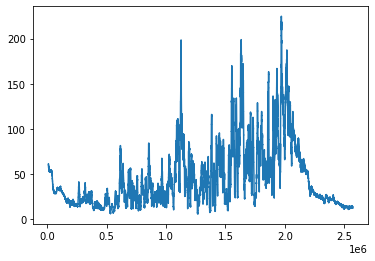

In [15]:
pd.Series(losses).rolling(10000).mean().plot()

<AxesSubplot:>

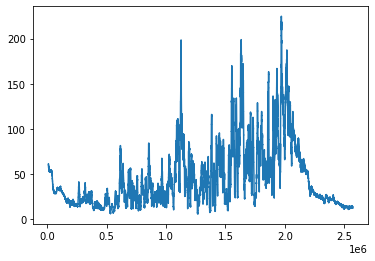

In [16]:
pd.Series(losses).rolling(10000).mean().plot()

In [17]:

def pp(Q_policy,env,g):
    env.goal_init_state=g
    val_2=0
    val_1=0

    el = env.maze.shape[0]


    man_ag = {}
    j = {}
    jv = {}
    j1v = {}
    # g=env.goal_init_state


    #             if Q_policy.expected_level == 0:
    #                 loc_idx2 = 0
    #                 g_idx2 = 0
    #             #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
    #             #                                                   Q_policy.expected_level)
    #             elif Q_policy.expected_level != env.n_layers:

    #                 loc_idx2, locs = Q_policy.get_subs([int(x / rf) for x in ns], env, current_level)

    #                 # loc_idx2 = int(ns[0] / 2) * 4 + int(ns[1] / 2)
    #                 g_idx2, locsg = Q_policy.get_subs([int(x / rf) for x in g], env, current_level)


    for level in range(env.n_layers):
        if level==0:
            g_idx2 = 0
        else:
            rf = env.manager_view ** (env.n_layers - level)
            g_idx2, locsg = Q_policy.get_subs([int(x / rf) for x in g], env, level)
        ml = env.manager_view**(env.n_layers-level)
        em = int(el / ml)

        print(level)
        man_ag[level]={}
        lisv = []
        sm = []
        for y in range(el):
            for j2 in range(el):
                a = env.get_super_manager_1([y, j2])

        #          a is manager e.g. 3,3
        #  what's the equivalent for manager to pass when getting task

                man_ag[level][y * el + j2] = a[level][0] * (el/env.manager_view**(env.n_layers-level)) + a[level][1]
                if a[level] not in sm:
                    lisv.append(y * el + j2)
                    sm.append(a[level])
        print(lisv)
        print(sm)
        j[level] = []
        jv[level] = []
        j1v[level] = []
        for i, s in enumerate(lisv):
            #     if int(s/8)+s%8<16:

            state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
            state[:el ** 2] = torch.tensor(env.maze.flatten())
            m = level

            aa = env.possible_actions(m, [int(s / el), s % el])
            loc_idx2, locs = Q_policy.get_subs(sm[i], env, level)
            if level==0:
                t=4

            else:
                p = int(man_ag[level-1][s])
            # p = int(s / 4) * 2 + int((s / 2) % 4)
                t = action_dict_r[j[level-1][p]]

            state[el ** 2:2 * el ** 2] = 0
            state[el ** 2 + g_idx2] = -100
            state[el ** 2 + loc_idx2] = 100

            state[2 * el ** 2 + m] = 1
            state[2 * el ** 2 + env.n_layers+1 + t] = 1
            #         print(state)

            j[level].append(action_dict[aa[torch.max(Q_policy.forward(state, level, env).flatten()[aa], axis=0)[1].item()]])
            j1v[level].append(torch.max(Q_policy.forward(state, level, env).flatten()[aa], axis=0)[0].item())
            jv[level].append([(x, Q_policy.forward(state, level, env).flatten()[x].item()) for x in aa])
        if level!=0:
            print(np.array(j[level]).reshape(em, em))
            print(np.array(jv[level]).reshape(em, em))
    j2 = []
    j2v = []
    value_list = {}
    for s in range(el ** 2):
        g_idx2 = int(env.maze.shape[0] * g[0] + g[1])
        #     if int(s/8)+s%8<16:
        state = torch.zeros(2 * el ** 2 + env.n_layers+1 +5)
        state[:el ** 2] = torch.tensor(env.maze.flatten())
        #         aa=env.possible_actions(m,[int(s/8),s%8])
    #     state[el ** 2:2 * el ** 2] = val_2
        m = env.n_layers
    #     this is used to find task
        p = int(man_ag[env.n_layers-1][s])
        # p = int(s / 4) * 2 + int((s / 2) % 4)
        t = action_dict_r[j[env.n_layers-1][p]]
    #     print(s,p,t)
    #     gm = env.get_super_manager_1([int(s / el), int(s % el)])[env.n_layers-1]
    #     for x in range(el ** 2):
    #         sm = env.get_super_manager_1([int(x / el), int(x % el)])[env.n_layers-1]
    #         if sm == gm:
    #             state[el ** 2 + x] = 0

        state[s + el ** 2] = 100
        state[g_idx2 + el ** 2] = -100
        state[2 * el ** 2 + m] = 1
        state[2 * el ** 2 + env.n_layers+1 + t] = 1
        #         print(p, s, m, t)
        #         print()
        #         print(state)
        if [int(s / el), int(s % el)] == g:
            j2.append('X')
            j2v.append(0)
        elif env.maze[int(s / el), int(s % el)] == 1:
            vv = Q_policy.forward(state, env.n_layers, env)
            j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
        else:
            vv = Q_policy.forward(state, env.n_layers, env)
            value_list[s] = vv.cpu().detach().numpy()
            j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    print(np.array(j2).reshape(el, el
                               ))
    print('xxx')

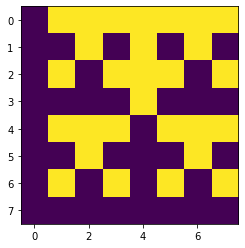

In [18]:
plt.imshow(env.maze)

In [19]:
for g in [[0,0],[0,7],[7,0],[7,7],[4,4]]:
    pp(Q_policy,env,g)

0
[0]
[[0, 0]]
1
[0, 2, 4, 6, 16, 18, 20, 22, 32, 34, 36, 38, 48, 50, 52, 54]
[[0.0, 0.0], [0.0, 1.0], [0.0, 2.0], [0.0, 3.0], [1.0, 0.0], [1.0, 1.0], [1.0, 2.0], [1.0, 3.0], [2.0, 0.0], [2.0, 1.0], [2.0, 2.0], [2.0, 3.0], [3.0, 0.0], [3.0, 1.0], [3.0, 2.0], [3.0, 3.0]]
[['Search' 'W' 'W' 'W']
 ['N' 'W' 'W' 'W']
 ['N' 'W' 'W' 'N']
 ['S' 'W' 'E' 'S']]
[[list([(4, -1.059690237045288)])
  list([(0, -13.20534610748291), (1, -19.511371612548828), (2, -10.194543838500977), (3, -2.2159860134124756)])
  list([(0, -17.6141414642334), (1, -21.417293548583984), (2, -19.018531799316406), (3, -12.79281997680664)])
  list([(0, -25.00981330871582), (1, -25.317359924316406), (2, -23.834901809692383), (3, -20.953369140625)])]
 [list([(0, -2.1596133708953857), (1, -7.718714714050293), (2, -9.183780670166016), (3, -6.926743984222412)])
  list([(0, -15.839037895202637), (1, -16.716466903686523), (2, -13.616015434265137), (3, -12.795369148254395)])
  list([(0, -21.88262176513672), (1, -24.855642318725586),

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



[[list([(0, -21.304691314697266), (1, -20.21794319152832), (2, -19.206640243530273), (3, -21.041637420654297)])
  list([(0, -17.89879608154297), (1, -16.62159538269043), (2, -13.440888404846191), (3, -18.061302185058594)])
  list([(0, -8.447698593139648), (1, -8.387456893920898), (2, -2.867065191268921), (3, -7.999720573425293)])
  list([(4, -0.8745803833007812)])]
 [list([(0, -20.5108699798584), (1, -20.901416778564453), (2, -20.8222713470459), (3, -25.771272659301758)])
  list([(0, -22.443105697631836), (1, -20.319664001464844), (2, -14.13299560546875), (3, -17.703298568725586)])
  list([(0, -12.170263290405273), (1, -12.032415390014648), (2, -9.759678840637207), (3, -12.580796241760254)])
  list([(0, -2.5291075706481934), (1, -7.959917068481445), (2, -10.13650131225586), (3, -7.093125343322754)])]
 [list([(0, -23.486019134521484), (1, -24.019840240478516), (2, -19.577945709228516), (3, -22.061981201171875)])
  list([(0, -17.90383529663086), (1, -19.69695472717285), (2, -15.69510364

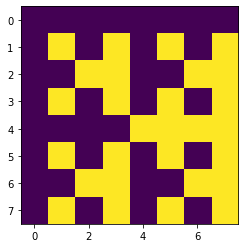

In [27]:
plt.imshow(env.maze)

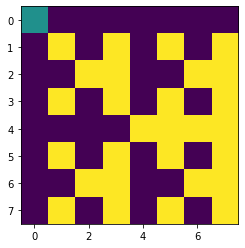

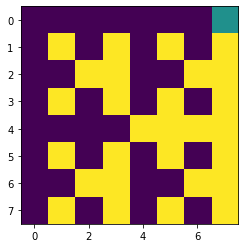

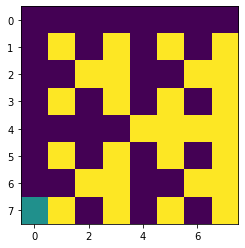

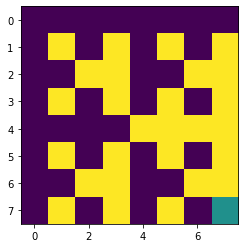

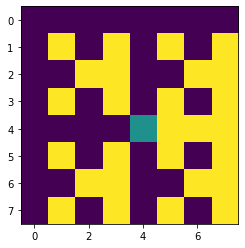

In [28]:
for g in [[0,0],[0,7],[7,0],[7,7],[4,4]]:
    z=copy.copy(env.maze)
            
            
    z[g[0],g[1]]=0.5

    plt.imshow(z)
    plt.show()
#     pp(Q_policy,env,g)

In [29]:
for g in [[0,0],[0,7],[7,0],[7,7]]:

    pp(Q_policy,env,g)

0
[0]
[[0, 0]]
1
[0, 2, 4, 6, 16, 18, 20, 22, 32, 34, 36, 38, 48, 50, 52, 54]
[[0.0, 0.0], [0.0, 1.0], [0.0, 2.0], [0.0, 3.0], [1.0, 0.0], [1.0, 1.0], [1.0, 2.0], [1.0, 3.0], [2.0, 0.0], [2.0, 1.0], [2.0, 2.0], [2.0, 3.0], [3.0, 0.0], [3.0, 1.0], [3.0, 2.0], [3.0, 3.0]]
[['Search' 'W' 'W' 'W']
 ['N' 'N' 'N' 'W']
 ['N' 'W' 'N' 'N']
 ['N' 'N' 'N' 'W']]
[[list([(4, -0.4854007065296173)])
  list([(0, -9.004853248596191), (1, -11.494328498840332), (2, -10.663928031921387), (3, -2.674206495285034)])
  list([(0, -14.825169563293457), (1, -13.99906063079834), (2, -16.676654815673828), (3, -7.339094638824463)])
  list([(0, -29.4185733795166), (1, -38.20595932006836), (2, -34.32451248168945), (3, -20.054441452026367)])]
 [list([(0, -2.642406463623047), (1, -11.504323959350586), (2, -13.590283393859863), (3, -13.614322662353516)])
  list([(0, -7.768815994262695), (1, -15.376577377319336), (2, -17.085460662841797), (3, -15.857635498046875)])
  list([(0, -11.862044334411621), (1, -20.26990127563476

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['X' 'E' 'W' 'W' 'W' 'W' 'W' 'W']
 ['S' 'ME' 'N' 'MS' 'N' 'MN' 'N' 'MW']
 ['N' 'N' 'MN' 'MN' 'N' 'W' 'MW' 'MW']
 ['N' 'MN' 'N' 'MN' 'N' 'ME' 'N' 'MW']
 ['N' 'E' 'W' 'W' 'MN' 'ME' 'MN' 'MW']
 ['N' 'ME' 'N' 'MW' 'N' 'ME' 'N' 'MW']
 ['N' 'W' 'MN' 'ME' 'N' 'W' 'MW' 'MW']
 ['N' 'ME' 'N' 'MN' 'N' 'MN' 'N' 'MW']]
xxx
0
[0]
[[0, 0]]
1
[0, 2, 4, 6, 16, 18, 20, 22, 32, 34, 36, 38, 48, 50, 52, 54]
[[0.0, 0.0], [0.0, 1.0], [0.0, 2.0], [0.0, 3.0], [1.0, 0.0], [1.0, 1.0], [1.0, 2.0], [1.0, 3.0], [2.0, 0.0], [2.0, 1.0], [2.0, 2.0], [2.0, 3.0], [3.0, 0.0], [3.0, 1.0], [3.0, 2.0], [3.0, 3.0]]
[['E' 'E' 'E' 'Search']
 ['E' 'N' 'N' 'N']
 ['N' 'N' 'N' 'N']
 ['N' 'N' 'N' 'N']]
[[list([(0, -10.81141185760498), (1, -10.404243469238281), (2, -9.204141616821289), (3, -10.130998611450195)])
  list([(0, -9.082999229431152), (1, -11.462835311889648), (2, -5.948361396789551), (3, -8.204948425292969)])
  list([(0, -8.5794095993042), (1, -9.337574005126953), (2, -3.399953842163086), (3, -9.579690933227539)])
  list